# Singular Pertubations Problem

In [2]:
#%matplotlib notebook
%matplotlib inline

# environment setting, before any codes
import numpy as np
import scipy.linalg as slinalg
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.legendre as npleg
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output, display

0.01

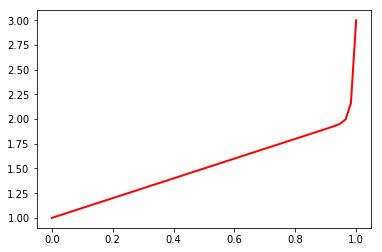

In [3]:
#The following functions will give us the exact solution of our boundary value problem

def exact_fun(x, alpha, beta, epsilon):
    return alpha + x + (beta - alpha - 1)*((np.exp(x/epsilon)-1)/(np.exp(1/epsilon)-1))

alpha = 1
beta = 3
epsilon = 0.01

number = 59
def draw_fun(number, alpha, beta, epsilon):
    x = np.linspace(0, 1, number)
    y = exact_fun(x, alpha, beta, epsilon)
    plt.plot(x,y,'r',linewidth=2)
    return epsilon
draw_fun(number, alpha, beta, epsilon)


In [4]:
#As we have a singular value problem, we must design a fine grid that will fit with our case

alpha = 1
beta = 3
epsilon = 0.01
m = 100
#We generate the uniform grid on [alpha, beta]

def generate_grid_y(left, right, m):
    h = (right - left)/(m+1)
    y = np.zeros(m+2)
    for j in range(m+2):
        y[j] = j*h+1
    return  y

y = generate_grid_y(alpha,beta, m)
#print(y)

#The method we use to design the grid is the dichotomy

def antecedent_k(exact_fun,k,a,b,e, alpha, beta, epsilon):
    start = a
    end = b
    #e stands for the error for the approximation
    gap = b-a
    while gap>e:
        
        m = (start+end)/2
        if exact_fun(m,alpha,beta,epsilon)>k:
            end = m
        else:
            start = m
        gap = end-start
    return m

#Now we generate the fine grid

def generate_grid(antecedent, antecedent_k, exact_fun,a,b,e,alpha,beta,epsilon):
    x = np.zeros(len(antecedent))
    for i in range (len(antecedent)):
        x[i] = antecedent_k(exact_fun,antecedent[i],a,b,e,alpha,beta,epsilon)
    return x
  
x = generate_grid(y, antecedent_k, exact_fun,0,1,10e-10,alpha,beta,epsilon)
#print(x)
x[0] = 0
x[-1] = 1


#We construct our matrice A and the vector F

def generate_A_interior(epsilon, m, x):
    A = np.zeros([m+2, m+2])
    for i in range(1,m+1):
        ci = 2/((x[i]-x[i-1])*(x[i]-x[i+1]))
        ci_left = 2/((x[i-1]-x[i])*(x[i-1]-x[i+1]))
        ci_right = 2/((x[i+1]-x[i])*(x[i+1]-x[i-1]))
        A[i, i-1] = epsilon*ci_left + 1/(x[i+1]-x[i-1])
        A[i, i] = epsilon*ci
        A[i, i+1] = epsilon*ci_right - 1/(x[i+1]-x[i-1])
    A[0,0] = 1
    A[-1,-1] = 1
    
    return A
A = generate_A_interior(epsilon, m, x)

def fun(x):
    return -1

def generate_F_interior(m, x, fun, alpha, beta):
    F = np.zeros(m+2)
    for i in range(1,m+1):
        F[i] = fun(x[i])
    F[0] = alpha
    F[-1] = beta
    return F

F = generate_F_interior(m, x, fun, alpha, beta)

In [5]:
def draw_approximation(m, alpha, beta, epsilon, fun):
    y = generate_grid_y(alpha, beta, m)
    x = generate_grid(y, antecedent_k, exact_fun,0,1,10e-10,alpha,beta,epsilon)
    A = generate_A_interior(epsilon, m, x)
    F = generate_F_interior(m, x, fun, alpha, beta)
    U = np.linalg.solve(A, F)
    u = exact_fun(x, alpha, beta, epsilon)
    plt.plot(x,U,'r',linewidth=2)
    plt.plot(x,u,'b',linewidth=2)
    Emax = np.max(np.abs(U-u))
    return Emax
#draw_fun(number, alpha, beta, epsilon)
w = interactive(draw_approximation, alpha=fixed(alpha), beta=fixed(beta), fun=fixed(fun), epsilon=fixed(epsilon),\
                m=widgets.IntSlider(min=1,max=100,step=1, value=1.00, description='$\nnumber:$',))
display(w)

interactive(children=(IntSlider(value=1, description='$\nnumber:$', min=1), Output()), _dom_classes=('widget-i…

24
26
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.0006843223880734772 99


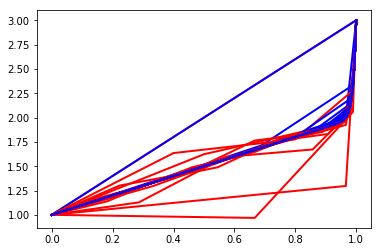

In [7]:
#Let's find the best value of m

Error = np.zeros(100)
for i in range(100):
    Error[i] = draw_approximation(i, alpha, beta, epsilon, fun)

Error = Error[1:len(Error)]
for i in range(len(Error)):
    if Error[i] < 10e-3:
        print(i+1)
bestError, best_m = min(Error), np.argmin(Error)+1
print(bestError, best_m)

#  Poisson Problem

To solve this first question, we use the 5-point Laplacian. We will order unknowns using natural rowwise ordering.

The matrix A looks like (Plot that matrix in the final document)

In [17]:
#Now we compute the matrices T and D

def generate_TD(N, dx, dy):
    T = np.zeros([N,N])
    a = (dy/dx)**2
    b = -2*(1 + a)
    for i in range(N):
        T[i,i] += b
        if (i < N-1):
            T[i,i+1] += a
        if (i > 0):
            T[i,i-1] += a
    D = np.identity(N)
    return T, D

#We can have a loook on the matrix A


def assemble_matrix_A(dx, dy, N, M):
    T, D = generate_TD(N, dx, dy)
    A = np.zeros([N*M, N*M])
    for j in range(M):
        A[j*N:(j+1)*N,j*N:(j+1)*N] += T
        if (j < M-1):
            A[j*N:(j+1)*N,(j+1)*N:(j+2)*N] += D
        if (j > 0):
            A[j*N:(j+1)*N,(j-1)*N:j*N] += D
    return A

N = 9
M = 9
dx = 1./(N+1)
dy = 1./(M+1)
T, D = generate_TD(N, dx, dy)
#print (T)
A = assemble_matrix_A(dx, dy, N, M)
#print (A)
#plt.spy(A)
#plt.show()


#We set boundary conditons
#We assume x and y are in the range [0,1]

def gL(y):
    return np.exp(y/2)

def gR(y):
    return np.exp(1+y/2)

def gB(x):
    return np.exp(x)

def gT(x):
    return np.exp(x+1/2)

#Right side

def f(x,y):
    return 1.25*(np.exp(x+y/2))

#We define the vector of the right side. We must take into consideration the boundary conditions

def assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT,f):
    b = np.zeros(N*M)
    # Left BCs
    for j in range(M):
        #b[(j-1)*N] += -(dy/dx)**2*gL(y[j+1]) #Change j-1 to j
        b[(j)*N] += -(dy/dx)**2*gL(y[j+1])
        
    for j in range(M):
        #b[(j-1)*N+N-1] += -(dy/dx)**2*gR(y[j+1]) #Change j-1 to j
        b[(j)*N+N-1] += -(dy/dx)**2*gR(y[j+1])
    
    # Bottom BCs
    for i in range(N):
        b[i] += -gB(x[i+1])
    
    # Top BCs:
    for i in range(N):
        b[(M-1)*N+i] += -gT(x[i+1])
        
    for i in range(N):
        for j in range(1,M+1):
            #b[(j-1)*N+i] += f(x[i+1],y[j]) #Adapt this source term
            b[(j-1)*N+i] += f(x[i+1],y[j])*(dy)**2
            
    return b
    



In [18]:
x = np.linspace(0, 1, N+2)
y = np.linspace(0, 1, M+2)
b = assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT,f)
v = np.linalg.solve(A,b)

In [19]:
def exact_solution(x,y):
    return np.exp(x+y/2)

#We can compute the vector of the exact solution
u_exc = np.zeros(N*M)
for i in range(N):
    for j in range(1,M+1):
        u_exc[(j-1)*N+i] += exact_solution(x[i+1],y[j])

In [20]:
print(u_exc, v)
Emax = np.max(np.abs(u_exc-v))
print(Emax)

[1.16183424 1.28402542 1.41906755 1.56831219 1.73325302 1.91554083
 2.11700002 2.33964685 2.58570966 1.22140276 1.34985881 1.4918247
 1.64872127 1.8221188  2.01375271 2.22554093 2.45960311 2.71828183
 1.28402542 1.41906755 1.56831219 1.73325302 1.91554083 2.11700002
 2.33964685 2.58570966 2.85765112 1.34985881 1.4918247  1.64872127
 1.8221188  2.01375271 2.22554093 2.45960311 2.71828183 3.00416602
 1.41906755 1.56831219 1.73325302 1.91554083 2.11700002 2.33964685
 2.58570966 2.85765112 3.15819291 1.4918247  1.64872127 1.8221188
 2.01375271 2.22554093 2.45960311 2.71828183 3.00416602 3.32011692
 1.56831219 1.73325302 1.91554083 2.11700002 2.33964685 2.58570966
 2.85765112 3.15819291 3.49034296 1.64872127 1.8221188  2.01375271
 2.22554093 2.45960311 2.71828183 3.00416602 3.32011692 3.66929667
 1.73325302 1.91554083 2.11700002 2.33964685 2.58570966 2.85765112
 3.15819291 3.49034296 3.85742553] [1.16185167 1.28405538 1.41910683 1.56835817 1.73330319 1.91559236
 2.11704932 2.33968896 2.5857

In [24]:
#Now we test the script on a non square domain

#Now we compute the matrices T and D

def generate_TD(N, dx, dy):
    T = np.zeros([N,N])
    a = (dy/dx)**2
    b = -2*(1 + a)
    for i in range(N):
        T[i,i] += b
        if (i < N-1):
            T[i,i+1] += a
        if (i > 0):
            T[i,i-1] += a
    D = np.identity(N)
    return T, D

#We can have a loook on the matrix A


def assemble_matrix_A(dx, dy, N, M):
    T, D = generate_TD(N, dx, dy)
    A = np.zeros([N*M, N*M])
    for j in range(M):
        A[j*N:(j+1)*N,j*N:(j+1)*N] += T
        if (j < M-1):
            A[j*N:(j+1)*N,(j+1)*N:(j+2)*N] += D
        if (j > 0):
            A[j*N:(j+1)*N,(j-1)*N:j*N] += D
    return A

N = 1
M = 19
dx = 1./(N+1)
dy = 1./(M+1)
T, D = generate_TD(N, dx, dy)
#print (T)
A = assemble_matrix_A(dx, dy, N, M)
#print (A)
#plt.spy(A)
#plt.show()


#We set boundary conditons
#We assume x is in the range [0,1] and y in the range [0,2]

def gL(y):
    return np.exp(y/2)

def gR(y):
    return np.exp(1+y/2)

def gB(x):
    return np.exp(x)

def gT(x):
    return np.exp(x+1) #This function changes in the considered case

#Right side

def f(x,y):
    return 1.25*(np.exp(x+y/2))

#We define the vector of the right side. We must take into consideration the boundary conditions

def assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT,f):
    b = np.zeros(N*M)
    # Left BCs
    for j in range(M):
        #b[(j-1)*N] += -(dy/dx)**2*gL(y[j+1]) #Change j-1 to j
        b[(j)*N] += -(dy/dx)**2*gL(y[j+1])
        
    for j in range(M):
        #b[(j-1)*N+N-1] += -(dy/dx)**2*gR(y[j+1]) #Change j-1 to j
        b[(j)*N+N-1] += -(dy/dx)**2*gR(y[j+1])
    
    # Bottom BCs
    for i in range(N):
        b[i] += -gB(x[i+1])
    
    # Top BCs:
    for i in range(N):
        b[(M-1)*N+i] += -gT(x[i+1])
        
    for i in range(N):
        for j in range(1,M+1):
            #b[(j-1)*N+i] += f(x[i+1],y[j]) #Adapt this source term
            b[(j-1)*N+i] += f(x[i+1],y[j])*(dy)**2
            
    return b

x = np.linspace(0, 1, N+2)
y = np.linspace(0, 2, M+2)
b = assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT,f)
v = np.linalg.solve(A,b)

def exact_solution(x,y):
    return np.exp(x+y/2)

#We can compute the vector of the exact solution
u_exc = np.zeros(N*M)
for i in range(N):
    for j in range(1,M+1):
        u_exc[(j-1)*N+i] += exact_solution(x[i+1],y[j])
        
print(u_exc, v)
Emax = np.max(np.abs(u_exc-v))
print(Emax)

[1.73325302 1.8221188  1.91554083 2.01375271 2.11700002 2.22554093
 2.33964685 2.45960311 2.58570966 2.71828183 2.85765112 3.00416602
 3.15819291 3.32011692 3.49034296 3.66929667 3.85742553 4.05519997
 4.26311452] [1.75836075 1.86949465 1.98261918 2.0981819  2.21658603 2.33819382
 2.46332876 2.59227673 2.72528625 2.86256757 3.00429077 3.15058271
 3.30152282 3.45713752 3.61739334 3.78218832 3.95134174 4.12458178
 4.30153099]
0.14663965113901556


In [27]:
#Now we test the script with dx different from dy

#Now we compute the matrices T and D

def generate_TD(N, dx, dy):
    T = np.zeros([N,N])
    a = (dy/dx)**2
    b = -2*(1 + a)
    for i in range(N):
        T[i,i] += b
        if (i < N-1):
            T[i,i+1] += a
        if (i > 0):
            T[i,i-1] += a
    D = np.identity(N)
    return T, D

#We can have a loook on the matrix A


def assemble_matrix_A(dx, dy, N, M):
    T, D = generate_TD(N, dx, dy)
    A = np.zeros([N*M, N*M])
    for j in range(M):
        A[j*N:(j+1)*N,j*N:(j+1)*N] += T
        if (j < M-1):
            A[j*N:(j+1)*N,(j+1)*N:(j+2)*N] += D
        if (j > 0):
            A[j*N:(j+1)*N,(j-1)*N:j*N] += D
    return A

N = 19
M = 9
dx = 1./(N+1)
dy = 1./(M+1)
T, D = generate_TD(N, dx, dy)
#print (T)
A = assemble_matrix_A(dx, dy, N, M)
#print (A)
#plt.spy(A)
#plt.show()


#We set boundary conditons
#We assume x is in the range [0,1] and y in the range [0,2]

def gL(y):
    return np.exp(y/2)

def gR(y):
    return np.exp(1+y/2)

def gB(x):
    return np.exp(x)

def gT(x):
    return np.exp(x+1/2) 

#Right side

def f(x,y):
    return 1.25*(np.exp(x+y/2))

#We define the vector of the right side. We must take into consideration the boundary conditions

def assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT,f):
    b = np.zeros(N*M)
    # Left BCs
    for j in range(M):
        #b[(j-1)*N] += -(dy/dx)**2*gL(y[j+1]) #Change j-1 to j
        b[(j)*N] += -(dy/dx)**2*gL(y[j+1])
        
    for j in range(M):
        #b[(j-1)*N+N-1] += -(dy/dx)**2*gR(y[j+1]) #Change j-1 to j
        b[(j)*N+N-1] += -(dy/dx)**2*gR(y[j+1])
    
    # Bottom BCs
    for i in range(N):
        b[i] += -gB(x[i+1])
    
    # Top BCs:
    for i in range(N):
        b[(M-1)*N+i] += -gT(x[i+1])
        
    for i in range(N):
        for j in range(1,M+1):
            #b[(j-1)*N+i] += f(x[i+1],y[j]) #Adapt this source term
            b[(j-1)*N+i] += f(x[i+1],y[j])*(dy)**2
            
    return b

x = np.linspace(0, 1, N+2)
y = np.linspace(0, 1, M+2)
b = assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT,f)
v = np.linalg.solve(A,b)

def exact_solution(x,y):
    return np.exp(x+y/2)

#We can compute the vector of the exact solution
u_exc = np.zeros(N*M)
for i in range(N):
    for j in range(1,M+1):
        u_exc[(j-1)*N+i] += exact_solution(x[i+1],y[j])
        
print(u_exc, v)
Emax = np.max(np.abs(u_exc-v))
print(Emax)

[1.10517092 1.16183424 1.22140276 1.28402542 1.34985881 1.41906755
 1.4918247  1.56831219 1.64872127 1.73325302 1.8221188  1.91554083
 2.01375271 2.11700002 2.22554093 2.33964685 2.45960311 2.58570966
 2.71828183 1.16183424 1.22140276 1.28402542 1.34985881 1.41906755
 1.4918247  1.56831219 1.64872127 1.73325302 1.8221188  1.91554083
 2.01375271 2.11700002 2.22554093 2.33964685 2.45960311 2.58570966
 2.71828183 2.85765112 1.22140276 1.28402542 1.34985881 1.41906755
 1.4918247  1.56831219 1.64872127 1.73325302 1.8221188  1.91554083
 2.01375271 2.11700002 2.22554093 2.33964685 2.45960311 2.58570966
 2.71828183 2.85765112 3.00416602 1.28402542 1.34985881 1.41906755
 1.4918247  1.56831219 1.64872127 1.73325302 1.8221188  1.91554083
 2.01375271 2.11700002 2.22554093 2.33964685 2.45960311 2.58570966
 2.71828183 2.85765112 3.00416602 3.15819291 1.34985881 1.41906755
 1.4918247  1.56831219 1.64872127 1.73325302 1.8221188  1.91554083
 2.01375271 2.11700002 2.22554093 2.33964685 2.45960311 2.5857

In [8]:
#Now we use the 9 points laplacian


#Now we compute the matrices T and D
#we assume dx = dy

def generate_TD(N, dx, dy):
    T = np.zeros([N,N])
    D = np.zeros([N,N])
    h = dx
    for i in range(N):
        T[i,i] += -20/(6*(h**2))
        if (i < N-1):
            T[i,i+1] += 4/(6*(h**2))
        if (i > 0):
            T[i,i-1] += 4/(6*(h**2))
    for i in range(N):
        D[i,i] = 4/(6*(h**2))
        if (i < N-1):
            D[i,i+1] += 1/(6*(h**2))
        if (i > 0):
            D[i,i-1] += 1/(6*(h**2))
    return T, D

#We can have a loook on the matrix A


def assemble_matrix_A(dx, dy, N, M):
    T, D = generate_TD(N, dx, dy)
    A = np.zeros([N*M, N*M])
    for j in range(M):
        A[j*N:(j+1)*N,j*N:(j+1)*N] += T
        if (j < M-1):
            A[j*N:(j+1)*N,(j+1)*N:(j+2)*N] += D
        if (j > 0):
            A[j*N:(j+1)*N,(j-1)*N:j*N] += D
    return A

N = M = 99
dx = 1./(N+1)
dy = 1./(M+1)
T, D = generate_TD(N, dx, dy)
#print (T)
A = assemble_matrix_A(dx, dy, N, M)
#print (A)
#plt.spy(A)
#plt.show()


#We set boundary conditons
#We assume x is in the range [0,1] and y in the range [0,2]

def gL(y):
    return np.exp(y/2)

def gR(y):
    return np.exp(1+y/2)

def gB(x):
    return np.exp(x)

def gT(x):
    return np.exp(x+1/2) 

#Right side

def f(x,y):
    return 1.25*(np.exp(x+y/2))

#We define the vector of the right side. We must take into consideration the boundary conditions

def assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT,f):
    b = np.zeros(N*M)
    h=dx
    # Left BCs
    for j in range(M):
        b[(j)*N] += -(4*gL(y[j+1])+gL(y[j])+gL(y[j+2]))/(6*(h**2))
        
    for j in range(M):
        b[(j)*N+N-1] += -(4*gR(y[j+1])+gR(y[j])+gR(y[j+2]))/(6*(h**2))
    
    # Bottom BCs
    for i in range(N):
        b[i] += -(4*gB(x[i+1])+gB(x[i])+gB(x[i+2]))//(6*(h**2))
    
    # Top BCs:
    for i in range(N):
        b[(M-1)*N+i] += -(4*gT(x[i+1])+gT(x[i])+gT(x[i+2]))//(6*(h**2))
        
    for i in range(N):
        for j in range(1,M+1):
            b[(j-1)*N+i] += f(x[i+1],y[j])*(dy)**2
            
    return b

x = np.linspace(0, 1, N+2)
y = np.linspace(0, 1, M+2)
b = assemble_vector_b(x, y, dx, dy, N, M, gL, gR, gB, gT,f)
v = np.linalg.solve(A,b)

def exact_solution(x,y):
    return np.exp(x+y/2)

#We can compute the vector of the exact solution
u_exc = np.zeros(N*M)
for i in range(N):
    for j in range(1,M+1):
        u_exc[(j-1)*N+i] += exact_solution(x[i+1],y[j])
        
print(u_exc, v)
Emax = np.max(np.abs(u_exc-v))
print(Emax)

[1.01511306 1.02531512 1.03561971 ... 4.32754324 4.37103577 4.41496541] [1.07290102 1.04280133 1.04311228 ... 4.35898506 4.44789338 4.67318935]
0.25822394217753164
